In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
torch.__version__

'1.1.0'

### 0. 定义超参数

In [74]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 查询GPU是否可用
BATCH_SIZE = 256 # Mini-batch大小
EPOCHES = 20 # 训练迭代次数

### 1. 获取MNIST数据集
（Pytorch中自带数据集，不过要联网下载）

In [75]:
mnist_train = datasets.MNIST('data', train = True, download = True,
                        transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
        ]))
mnist_test = datasets.MNIST('data', train = False, download = True,
                        transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                        ]))

### 2. 创建数据集迭代器

In [76]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size = 256, shuffle = True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size = 256, shuffle = True)

### 3. 可视化单批量数据集

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


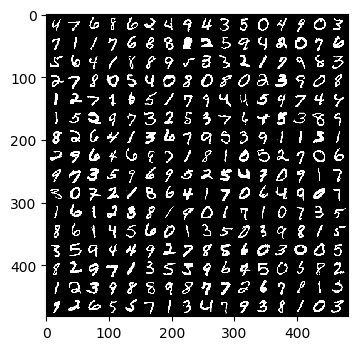

In [77]:
def show_batch(data, nrow):
    batch_img = torchvision.utils.make_grid(data, nrow)
    batch_img = np.array(batch_img)
    img = batch_img.transpose((1, 2, 0)) # Pytorch与Numpy存储数据结构不同
    plt.figure(dpi = 100)
    plt.imshow(img)
    
for idx, (data, label) in enumerate(train_loader):  
    show_batch(data, 16)
    break

### 4. LeNet5网络结构
<img src = "LeNet5.png" width = "80%">

下面除了最后的输出层没用径向基函数单元外，其他基本保持一致.

由于C3层采用了如下不对称连接，因此看起来似乎有点复杂:
<img src = "C3.png" width = "40%">

In [78]:
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.C1 = nn.Conv2d(1, 6, kernel_size = 5, stride = 1, padding = 2)
        self.C31 = torch.nn.Conv2d(3, 1, kernel_size = 5, stride = 1, padding = 0)
        self.C32 = torch.nn.Conv2d(4, 1, kernel_size = 5, stride = 1, padding = 0)
        self.C33 = torch.nn.Conv2d(6, 1, kernel_size = 5, stride = 1, padding = 0)
        self.C5 = torch.nn.Conv2d(16, 120, kernel_size = 5, stride = 1, padding = 0)
        self.F6 = torch.nn.Linear(120, 84)
        self.OUT = torch.nn.Linear(84, 10)
        
    def forward(self, x):
        out = self.C1(x)
        out = F.relu(out)
        out = F.max_pool2d(out, 2, 2)
        C3_OUT0 = self.C31(out[:, [0, 1, 2]])
        C3_OUT1 = self.C31(out[:, [1, 2, 3]])
        C3_OUT2 = self.C31(out[:, [2, 3, 4]])
        C3_OUT3 = self.C31(out[:, [3, 4, 5]])
        C3_OUT4 = self.C31(out[:, [4, 5, 0]])
        C3_OUT5 = self.C31(out[:, [5, 0, 1]])
        C3_OUT6 = self.C32(out[:, [0, 1, 2, 3]])
        C3_OUT7 = self.C32(out[:, [1, 2, 3, 4]])
        C3_OUT8 = self.C32(out[:, [2, 3, 4, 5]])
        C3_OUT9 = self.C32(out[:, [3, 4, 5, 0]])
        C3_OUT10 = self.C32(out[:, [4, 5, 0, 1]])
        C3_OUT11 = self.C32(out[:, [5, 0, 1, 2]])
        C3_OUT12 = self.C32(out[:, [0, 1, 3, 4]])
        C3_OUT12 = self.C32(out[:, [0, 1, 3, 4]])
        C3_OUT13 = self.C32(out[:, [1, 2, 4, 5]])
        C3_OUT14 = self.C32(out[:, [0, 2, 3, 5]])
        C3_OUT15 = self.C33(out)
        out = torch.cat((C3_OUT0, C3_OUT1, C3_OUT2, C3_OUT3, C3_OUT4, C3_OUT5, C3_OUT6, C3_OUT7, \
                   C3_OUT8, C3_OUT9, C3_OUT10, C3_OUT11, C3_OUT12, C3_OUT13, C3_OUT14, C3_OUT15), 1)
        out = F.relu(out)
        out = F.max_pool2d(out, 2, 2)
        out = self.C5(out)
        out = F.relu(out)
        out = out.view(-1, 120)
        out = self.F6(out)
        out = F.relu(out)
        out = self.OUT(out)
        return out

### 5. 实例化模型、优化方法、损失函数

In [79]:
model = LeNet5().to(DEVICE)
optimizer = optim.Adam(model.parameters())
lossfunc = nn.CrossEntropyLoss()

### 6. 训练和测试函数

In [80]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        # print(output, target)
        loss = lossfunc(output, label)
        loss.backward()
        optimizer.step()
        if (idx + 1) % 60 == 0:
            print('Iteration:{} [{}/{} ({:.1f}%)]\tLoss:{:.6f}'.format(epoch, idx * len(data), len(train_loader.dataset),
                                                                       100. * idx / len(train_loader), loss.item()))
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            loss = lossfunc(output, label)
            test_loss += loss 
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(label.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [81]:
for i in range(1, EPOCHES + 1):
    train(model, DEVICE, train_loader, optimizer, i)
    test(model, DEVICE, test_loader)

Iteration:1 [15104/60000 (25.1%)]	Loss:0.448448
Iteration:1 [30464/60000 (50.6%)]	Loss:0.314048
Iteration:1 [45824/60000 (76.2%)]	Loss:0.236309

Test set: Average loss: 0.0008, Accuracy: 9345/10000 (93%)

Iteration:2 [15104/60000 (25.1%)]	Loss:0.129724
Iteration:2 [30464/60000 (50.6%)]	Loss:0.247547
Iteration:2 [45824/60000 (76.2%)]	Loss:0.123488

Test set: Average loss: 0.0004, Accuracy: 9689/10000 (97%)

Iteration:3 [15104/60000 (25.1%)]	Loss:0.084803
Iteration:3 [30464/60000 (50.6%)]	Loss:0.103721
Iteration:3 [45824/60000 (76.2%)]	Loss:0.052022

Test set: Average loss: 0.0003, Accuracy: 9775/10000 (98%)

Iteration:4 [15104/60000 (25.1%)]	Loss:0.115766
Iteration:4 [30464/60000 (50.6%)]	Loss:0.074479
Iteration:4 [45824/60000 (76.2%)]	Loss:0.081462

Test set: Average loss: 0.0002, Accuracy: 9819/10000 (98%)

Iteration:5 [15104/60000 (25.1%)]	Loss:0.082233
Iteration:5 [30464/60000 (50.6%)]	Loss:0.028344
Iteration:5 [45824/60000 (76.2%)]	Loss:0.061126

Test set: Average loss: 0.0002, Acc